# Exploratory Data Analysis (EDA)
## Sentiment-Based BTC Directional Model (1H)

### Scope and Objectives

This EDA focuses on the **sentiment-driven component** of a BTC price prediction system.
The goal is **not** to build or evaluate models here, but to:

1. Justify data selection and preprocessing decisions.
2. Assess data quality and temporal consistency.
3. Understand the statistical behavior of sentiment-based features.
4. Evaluate whether sentiment signals exhibit any relationship with future BTC returns.

This notebook **does not** cover:
- Technical indicators derived from prices.
- Time-series forecasting models (ARIMA, SARIMA, etc.).

Those components are handled separately and combined later at the ensemble level.


## 1. Data Sources & Pipeline Overview

The sentiment dataset used in this project is built through the following pipeline:

1. **Raw news ingestion**
   - Source: NewsAPI
   - Output: raw news articles with timestamps and metadata

2. **Sentiment analysis**
   - NLP models applied to news text
   - Sentiment scores computed per thematic axis (BTC, MACRO, TECH)

3. **Temporal aggregation**
   - Aggregation to 1-hour granularity
   - Statistical features: mean, std, counts, rolling metrics, lags, shocks

4. **External context**
   - Fear & Greed Index merged at hourly resolution (forward-filled)

5. **Target construction**
   - BTC price series merged
   - Future return and directional target computed (1h horizon)

This EDA evaluates the final output of this pipeline and documents the rationale behind all major design decisions.


In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_theme(style="darkgrid")

# ===============================
# PROJECT ROOT
# ===============================
CURRENT_DIR = os.getcwd()
if os.path.basename(CURRENT_DIR) == "notebooks":
    PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, ".."))
else:
    PROJECT_ROOT = CURRENT_DIR

FINAL_1H_PATH = os.path.join(PROJECT_ROOT, "data/processed/dataset_sentiment_target_1h.csv")
OLD_1H_PATH   = os.path.join(PROJECT_ROOT, "data/processed/sentiment_only_1h.csv")
NEWS_RAW_PATH = os.path.join(PROJECT_ROOT, "data/raw/news_raw.csv")

CUTOFF = pd.Timestamp("2025-11-12 00:00:00", tz="UTC")

def load_final_dataset(path):
    df = pd.read_csv(path)
    if "datetime" not in df.columns:
        raise ValueError(f"FINAL dataset must contain 'datetime'. Columns: {list(df.columns)}")
    df["datetime"] = pd.to_datetime(df["datetime"], utc=True, errors="raise")
    return df.sort_values("datetime").reset_index(drop=True)

def load_old_dataset(path):
    df = pd.read_csv(path)

    # robust timestamp detection for OLD file
    possible_ts = ["datetime", "published_at", "publishedAt", "Unnamed: 0", "timestamp", "date"]
    ts_col = next((c for c in possible_ts if c in df.columns), None)

    if ts_col is None:
        raise ValueError(f"OLD dataset: no timestamp column found. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], utc=True, errors="coerce")
    df = df.rename(columns={ts_col: "datetime"})
    return df.sort_values("datetime").reset_index(drop=True)

def load_news_raw(path):
    df = pd.read_csv(path)

    # robust timestamp detection for raw news
    possible_ts = ["published_at", "publishedAt", "datetime", "date"]
    ts_col = next((c for c in possible_ts if c in df.columns), None)

    if ts_col is None:
        raise ValueError(f"NEWS raw: no timestamp column found. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], utc=True, errors="coerce")
    df = df.rename(columns={ts_col: "published_at"})
    return df.sort_values("published_at").reset_index(drop=True)


df_final = load_final_dataset(FINAL_1H_PATH)
df_old   = load_old_dataset(OLD_1H_PATH)
df_news  = load_news_raw(NEWS_RAW_PATH)

print("FINAL dataset:", df_final.shape)
print("OLD dataset:", df_old.shape)
print("RAW news:", df_news.shape)

display(df_final.head())


FINAL dataset: (1647, 37)
OLD dataset: (14939, 31)
RAW news: (11754, 5)


,datetime,sentiment_mean_BTC,sentiment_mean_MACRO,sentiment_mean_TECH,sentiment_count_BTC,sentiment_count_MACRO,sentiment_count_TECH,sentiment_std_BTC,sentiment_std_MACRO,sentiment_std_TECH,sentiment_total_mean,total_count,sentiment_mean_BTC_roll_mean,sentiment_mean_BTC_roll_std,sentiment_mean_BTC_shock,sentiment_mean_BTC_momentum,sentiment_mean_MACRO_roll_mean,sentiment_mean_MACRO_roll_std,sentiment_mean_MACRO_shock,sentiment_mean_MACRO_momentum,sentiment_mean_TECH_roll_mean,sentiment_mean_TECH_roll_std,sentiment_mean_TECH_shock,sentiment_mean_TECH_momentum,sentiment_total_mean_roll_mean,sentiment_total_mean_roll_std,sentiment_total_mean_shock,sentiment_total_mean_momentum,sentiment_mean_BTC_lag1,sentiment_mean_MACRO_lag1,sentiment_mean_TECH_lag1,sentiment_total_mean_lag1,div_btc_macro,news_ratio_btc_macro,fear_greed_index,future_return,target_up
0,2025-11-12 00:00:00+00:00,-0.236846,0.016076,-0.235350,5.0,4.0,1.0,0.0,0.0,0.0,-0.135528,10,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.252921,1.250000,24.0,0.003257,1
1,2025-11-12 01:00:00+00:00,-0.542562,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,-0.542562,4,0.000000,0.000000,0,-0.305717,0.000000,0.000000,0,-0.016076,0.000000,0.000000,0,0.235350,0.000000,0.000000,0,-0.407035,-0.236846,0.016076,-0.235350,-0.135528,-0.542562,NaN,24.0,-0.001151,0
2,2025-11-12 02:00:00+00:00,0.410395,-0.797744,0.000000,2.0,1.0,0.0,0.0,0.0,0.0,0.007682,3,0.000000,0.000000,0,0.952958,0.000000,0.000000,0,-0.797744,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.550245,-0.542562,0.000000,0.000000,-0.542562,1.208140,1.999998,24.0,0.001635,1
3,2025-11-12 03:00:00+00:00,0.063836,0.289980,-0.361239,3.0,1.0,1.0,0.0,0.0,0.0,0.024050,5,-0.123004,0.486572,0,-0.346559,-0.260556,0.465288,0,1.087724,-0.078450,0.135879,-1,-0.361239,-0.223469,0.285469,0,0.016368,0.410395,-0.797744,0.000000,0.007682,-0.226144,2.999997,24.0,-0.001033,0
4,2025-11-12 04:00:00+00:00,0.000000,-0.013739,0.000000,1.0,6.0,0.0,0.0,0.0,0.0,-0.011777,7,-0.076294,0.408120,0,-0.063836,-0.122922,0.469149,0,-0.303719,-0.149147,0.179726,0,0.361239,-0.161590,0.263903,0,-0.035826,0.063836,0.289980,-0.361239,0.024050,0.013739,0.166667,24.0,0.001782,1


## 3. Temporal Coverage & Regime Analysis

Before analyzing features, it is critical to verify whether the dataset is temporally homogeneous.

Earlier iterations of this project relied on heterogeneous historical datasets
with inconsistent frequencies and incomplete coverage.

This section demonstrates why a **temporal cutoff (2025-11-12)** is required
to ensure semantic consistency and model reliability.


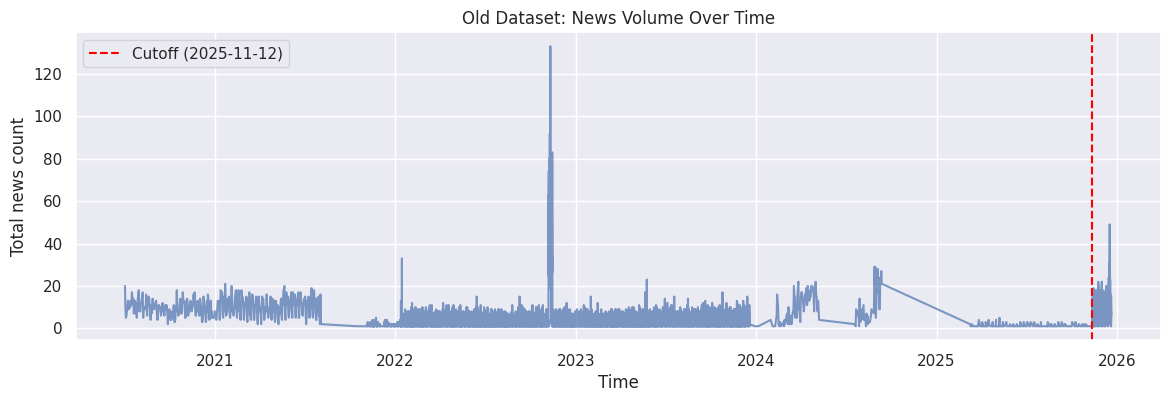

Rows before cutoff: 14040
Rows after cutoff : 899


In [23]:
plt.figure(figsize=(14,4))
plt.plot(df_old["datetime"], df_old["total_count"], alpha=0.7)
plt.axvline(CUTOFF, color="red", linestyle="--", label="Cutoff (2025-11-12)")
plt.title("Old Dataset: News Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Total news count")
plt.legend()
plt.show()

print("Rows before cutoff:", (df_old["datetime"] < CUTOFF).sum())
print("Rows after cutoff :", (df_old["datetime"] >= CUTOFF).sum())


The historical dataset exhibits clear regime changes:
- Long periods with sparse or irregular news coverage.
- Sections with daily data expanded to hourly resolution.
- Entire thematic axes missing in early periods.

Using such data for model training would introduce semantic noise.
Therefore, only data **after the cutoff** is considered valid for modeling.


## 4. Raw News Input Quality

This section evaluates the quality and continuity of the raw news input.
Its purpose is to show that, after the cutoff, the pipeline receives a
stable and continuous stream of information.


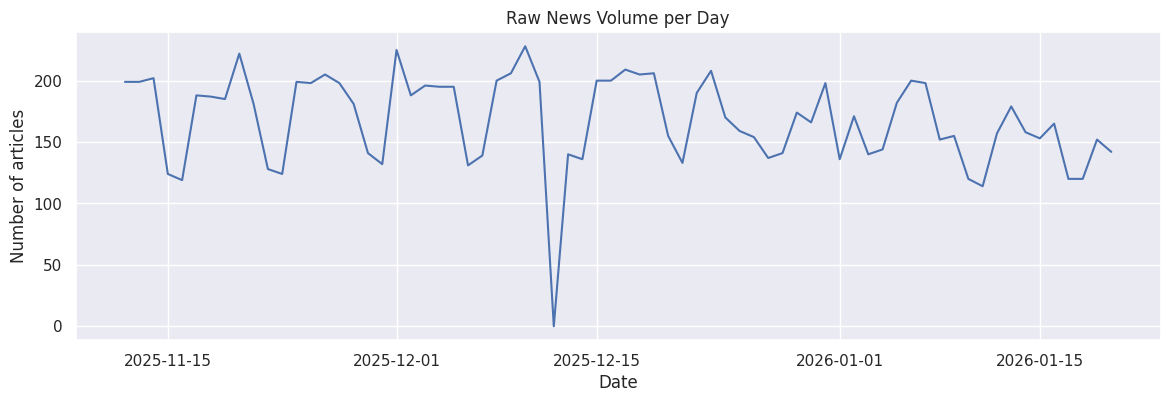

description     0.019908
axis            0.000170
source          0.000170
published_at    0.000085
title           0.000000
dtype: float64

In [24]:
news_daily = df_news.set_index("published_at").resample("1D").size()

plt.figure(figsize=(14,4))
plt.plot(news_daily.index, news_daily.values)
plt.title("Raw News Volume per Day")
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.show()

display(df_news.isna().mean().sort_values(ascending=False).head(15))


After November 2025, the raw input shows:
- Continuous daily coverage.
- Reasonable and stable article volume.
- Missing values concentrated in optional metadata fields.

This confirms that zero-valued sentiment features in later stages
correspond to **hours without news**, not missing data.

## 5. Final Dataset Sanity Check

This section validates the integrity of the final modeling dataset.


In [25]:
print("Coverage:", df_final["datetime"].min(), "→", df_final["datetime"].max())
print("All timestamps >= cutoff:", (df_final["datetime"] >= CUTOFF).all())

display(df_final.isna().mean().sort_values(ascending=False).head(15))
display((df_final == 0).mean().sort_values(ascending=False).head(15))


Coverage: 2025-11-12 00:00:00+00:00 → 2026-01-20 22:00:00+00:00
All timestamps >= cutoff: True


news_ratio_btc_macro           0.262295
sentiment_mean_BTC             0.000000
sentiment_mean_MACRO           0.000000
sentiment_mean_TECH            0.000000
datetime                       0.000000
sentiment_count_BTC            0.000000
sentiment_count_MACRO          0.000000
sentiment_std_BTC              0.000000
sentiment_count_TECH           0.000000
sentiment_std_TECH             0.000000
sentiment_total_mean           0.000000
total_count                    0.000000
sentiment_std_MACRO            0.000000
sentiment_mean_BTC_roll_std    0.000000
sentiment_mean_BTC_shock       0.000000
dtype: float64

sentiment_std_MACRO             1.000000
sentiment_std_BTC               1.000000
sentiment_std_TECH              1.000000
sentiment_mean_BTC_shock        0.882210
sentiment_mean_MACRO_shock      0.877960
sentiment_total_mean_shock      0.876138
sentiment_mean_TECH_shock       0.862781
target_up                       0.533698
sentiment_mean_TECH_lag1        0.426837
sentiment_mean_TECH             0.426837
sentiment_count_TECH            0.407407
sentiment_mean_TECH_momentum    0.238616
sentiment_mean_MACRO            0.231937
sentiment_mean_MACRO_lag1       0.231937
sentiment_count_MACRO           0.221008
dtype: float64

## 6. Target Analysis

The target variable represents BTC price movement one hour into the future.
Before analyzing features, we verify that the target is well-defined and stable.


target_up
0    0.533698
1    0.466302
Name: proportion, dtype: float64

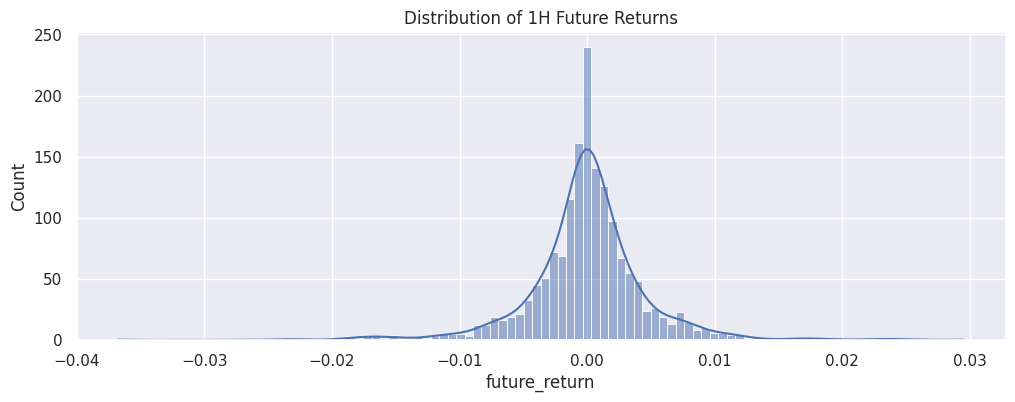

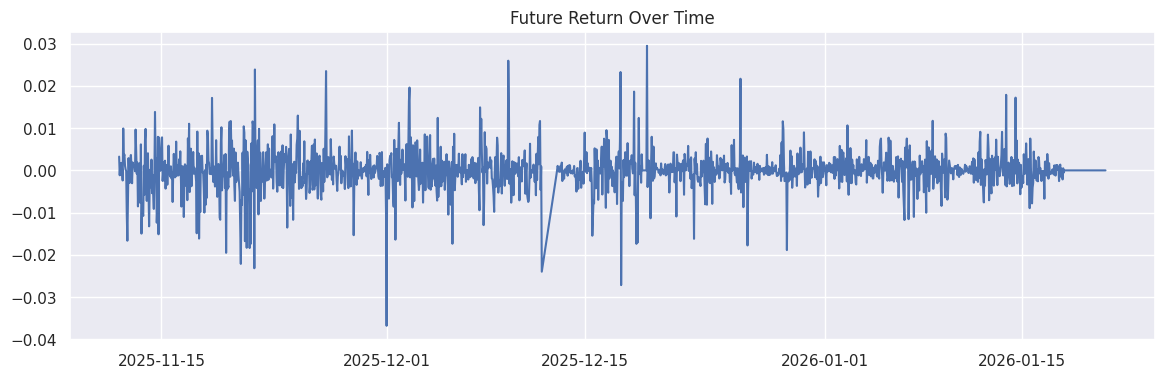

In [26]:
display(df_final["target_up"].value_counts(normalize=True))

plt.figure(figsize=(12,4))
sns.histplot(df_final["future_return"], bins=100, kde=True)
plt.title("Distribution of 1H Future Returns")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df_final["datetime"], df_final["future_return"])
plt.title("Future Return Over Time")
plt.show()


## 7. Feature Distributions

This section examines the marginal distributions of key sentiment-based features.
The goal is to identify degenerate variables, extreme skewness, or scaling issues.


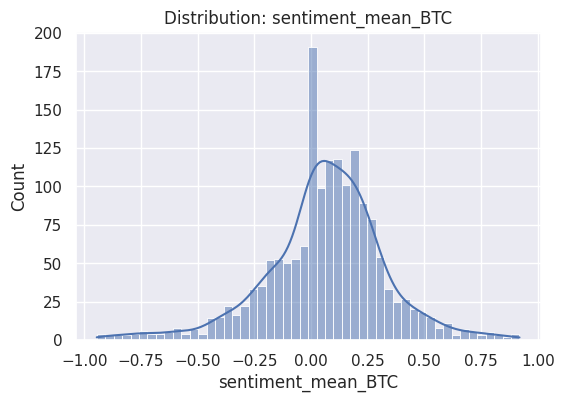

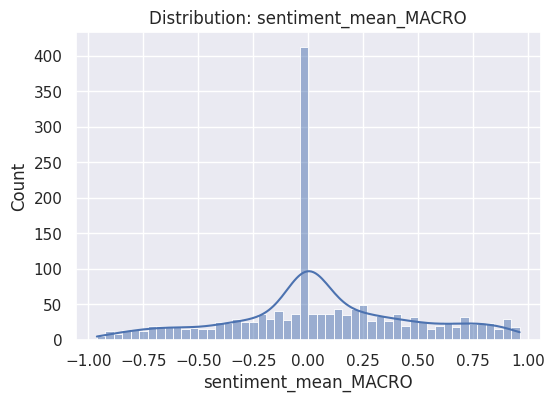

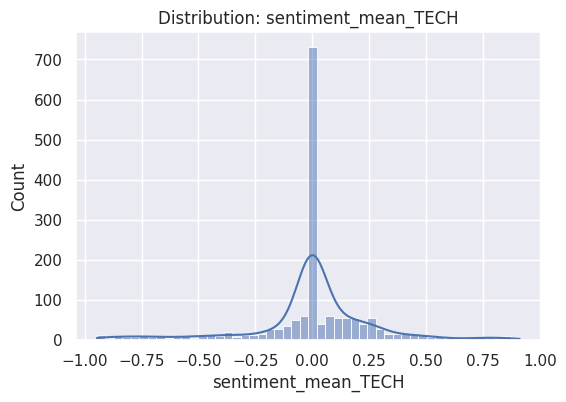

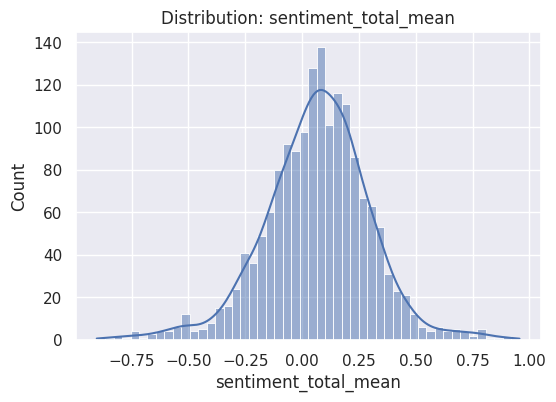

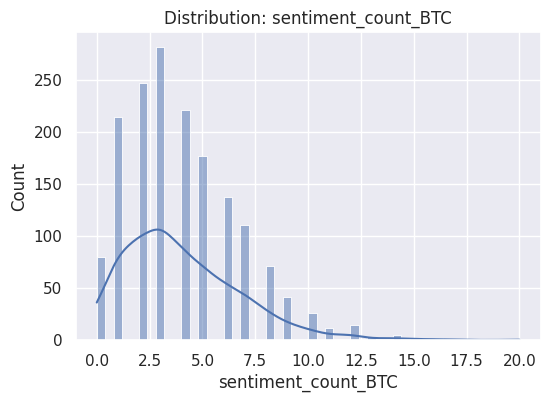

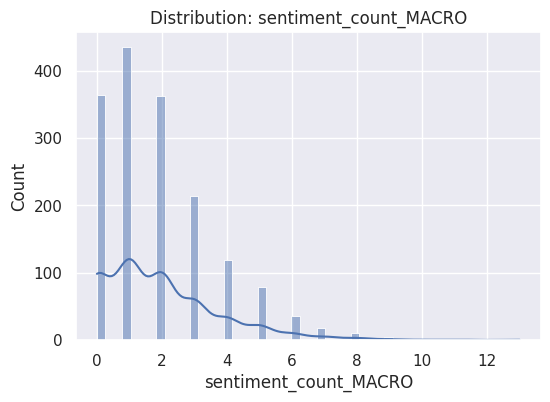

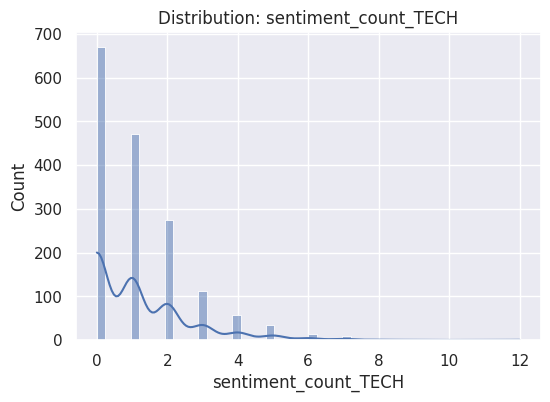

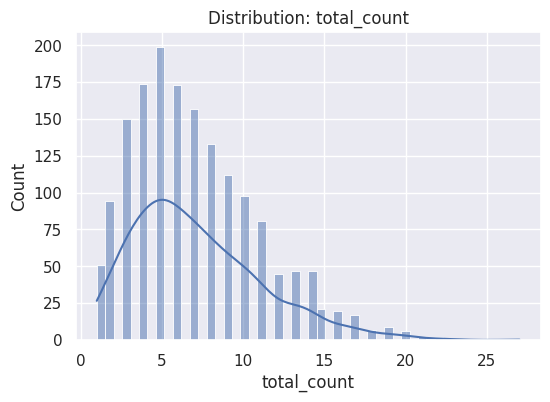

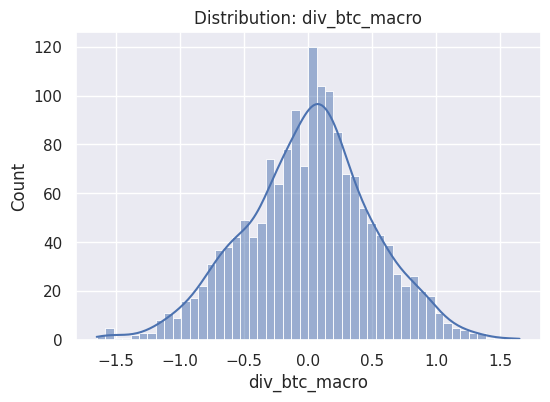

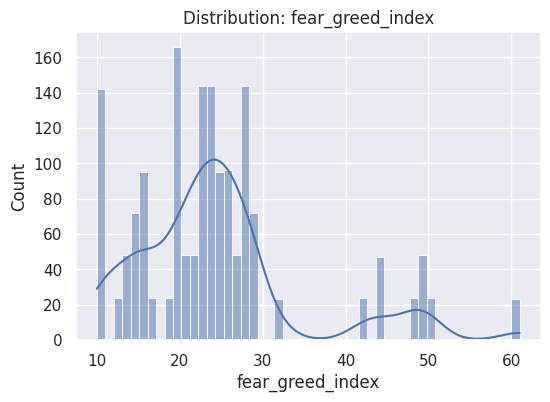

In [27]:
core_features = [
    "sentiment_mean_BTC","sentiment_mean_MACRO","sentiment_mean_TECH",
    "sentiment_total_mean",
    "sentiment_count_BTC","sentiment_count_MACRO","sentiment_count_TECH","total_count",
    "div_btc_macro","fear_greed_index"
]

for col in core_features:
    if col in df_final.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_final[col], bins=50, kde=True)
        plt.title(f"Distribution: {col}")
        plt.show()


## 8. Temporal Behavior of Features

Sentiment signals are typically episodic and non-stationary.
Visualizing their evolution helps assess their potential predictive role.


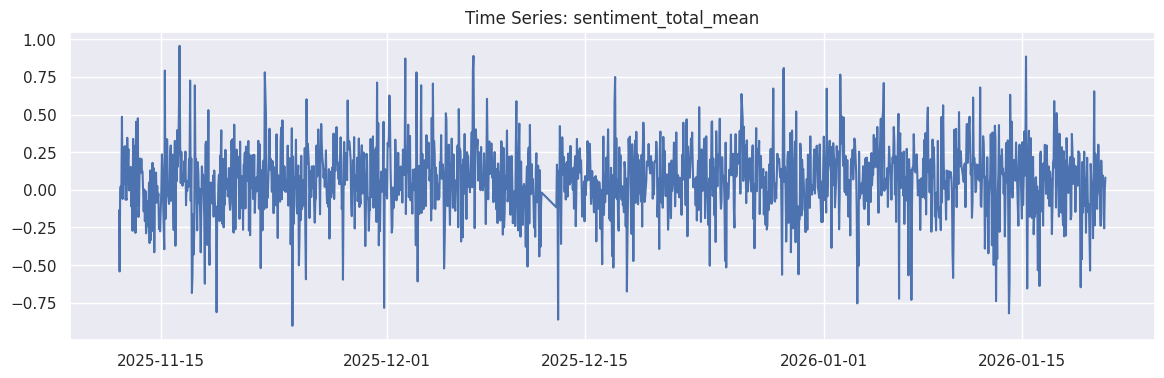

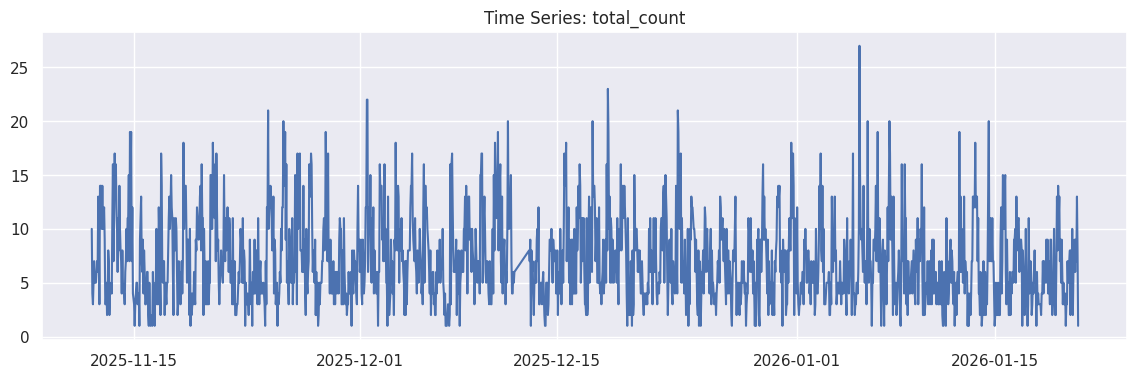

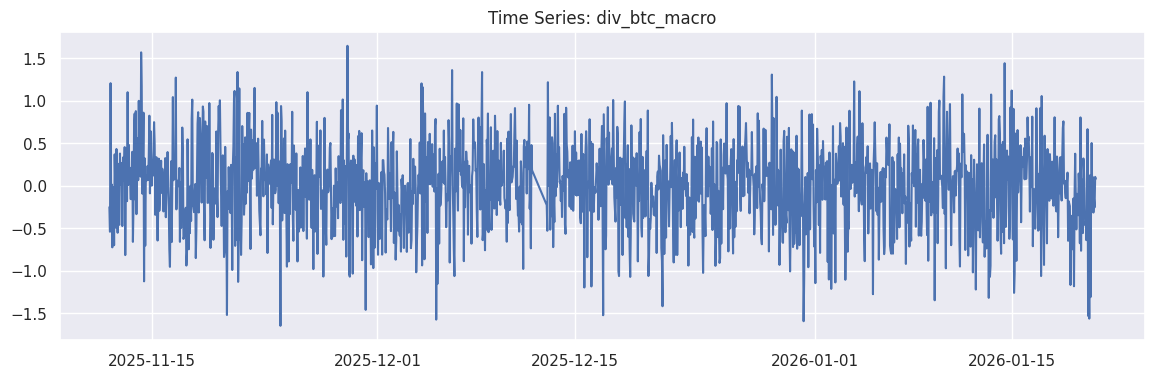

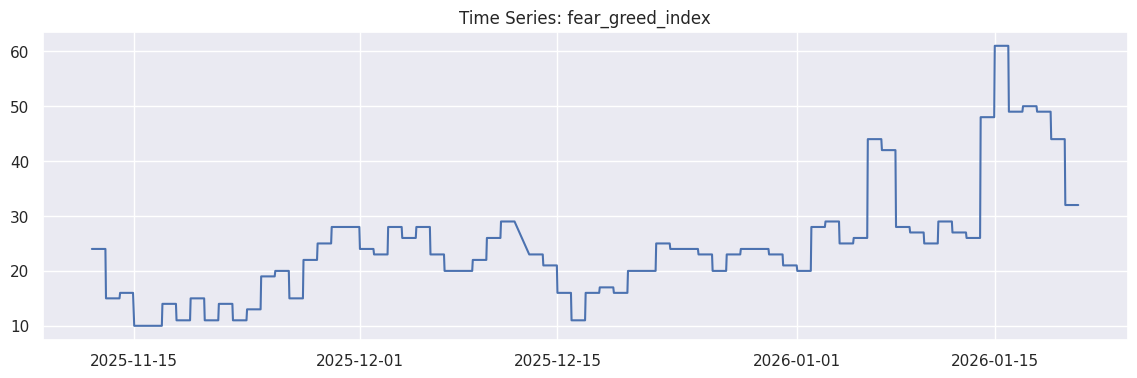

In [28]:
signals = [
    "sentiment_total_mean",
    "total_count",
    "div_btc_macro",
    "fear_greed_index"
]

for col in signals:
    plt.figure(figsize=(14,4))
    plt.plot(df_final["datetime"], df_final[col])
    plt.title(f"Time Series: {col}")
    plt.show()


## 9. Feature–Target Relationships

This section explores simple linear relationships between features
and the target variables. Correlation does not imply causation,
but provides a first-order signal assessment.


In [29]:
numeric_cols = df_final.select_dtypes(include="number").columns
corr_return = df_final[numeric_cols].corrwith(df_final["future_return"]).sort_values(key=np.abs, ascending=False)
corr_class  = df_final[numeric_cols].corrwith(df_final["target_up"]).sort_values(key=np.abs, ascending=False)

display(corr_return.head(15))
display(corr_class.head(15))


/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


future_return                     1.000000
target_up                         0.631713
sentiment_mean_BTC_roll_std      -0.073628
sentiment_mean_TECH_shock         0.050719
sentiment_mean_TECH               0.043914
sentiment_total_mean_roll_std    -0.040572
sentiment_mean_TECH_roll_std     -0.039823
sentiment_mean_TECH_momentum      0.031863
sentiment_mean_TECH_roll_mean     0.031759
sentiment_mean_BTC_lag1          -0.031478
sentiment_total_mean_shock       -0.025954
sentiment_total_mean_roll_mean    0.024781
sentiment_count_MACRO            -0.022275
sentiment_mean_BTC               -0.021315
sentiment_mean_MACRO_roll_mean    0.014965
dtype: float64

target_up                         1.000000
future_return                     0.631713
fear_greed_index                 -0.078414
sentiment_mean_BTC_roll_std      -0.060982
sentiment_total_mean              0.057447
sentiment_mean_BTC                0.051609
sentiment_mean_BTC_shock          0.051302
sentiment_mean_BTC_roll_mean      0.047158
sentiment_mean_TECH               0.040195
sentiment_total_mean_roll_std    -0.036412
sentiment_mean_TECH_shock         0.034164
sentiment_total_mean_roll_mean    0.033581
sentiment_total_mean_momentum     0.033564
sentiment_mean_TECH_roll_mean     0.032154
sentiment_mean_MACRO_lag1        -0.029154
dtype: float64

## 10. Conditional Analysis

Rather than relying solely on correlations, this section analyzes
how the target behaves under different sentiment regimes.


In [30]:
def conditional_analysis(feature, bins=5):
    s = df_final[[feature, "future_return", "target_up"]].dropna()
    s["bin"] = pd.qcut(s[feature], q=bins, duplicates="drop")
    return s.groupby("bin").agg(
        count=("future_return","size"),
        mean_return=("future_return","mean"),
        up_rate=("target_up","mean")
    )

for f in ["sentiment_total_mean","div_btc_macro","fear_greed_index","total_count"]:
    if f in df_final.columns:
        display(conditional_analysis(f))


/tmp/ipykernel_909/2488159517.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return s.groupby("bin").agg(


,count,mean_return,up_rate
bin,,,
"(-0.904, -0.109]",330,-0.000108,0.418182
"(-0.109, 0.0271]",329,-0.000271,0.455927
"(0.0271, 0.126]",329,0.000153,0.495441
"(0.126, 0.239]",329,0.000085,0.477204
"(0.239, 0.956]",330,-0.000041,0.484848


/tmp/ipykernel_909/2488159517.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return s.groupby("bin").agg(


,count,mean_return,up_rate
bin,,,
"(-1.652, -0.422]",330,-0.000237,0.436364
"(-0.422, -0.0947]",329,0.000263,0.480243
"(-0.0947, 0.129]",329,0.000267,0.504559
"(0.129, 0.399]",329,-0.000351,0.422492
"(0.399, 1.649]",330,-0.000122,0.487879


/tmp/ipykernel_909/2488159517.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return s.groupby("bin").agg(


,count,mean_return,up_rate
bin,,,
"(9.999, 16.0]",381,-0.000309,0.482940
"(16.0, 22.0]",310,0.000117,0.493548
"(22.0, 25.0]",383,0.000121,0.498695
"(25.0, 28.0]",288,-0.000001,0.468750
"(28.0, 61.0]",285,-0.000084,0.368421


/tmp/ipykernel_909/2488159517.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return s.groupby("bin").agg(


,count,mean_return,up_rate
bin,,,
"(0.999, 4.0]",469,-0.000081,0.447761
"(4.0, 5.0]",199,0.000192,0.462312
"(5.0, 7.0]",330,-0.000008,0.515152
"(7.0, 10.0]",343,-0.000179,0.425656
"(10.0, 27.0]",306,0.000015,0.490196
